In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thesisInitial.cleaning_data import extract_data_from_house, \
    extract_rated_power, extract_average_time_on, apply_new_load, generate_load
import seaborn as sns
import thesisInitial.tariff as tf
import time
from os import path
from os import getcwd, listdir

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

path_to_data = path.join('..', 'data')
houses = listdir(path.join(path_to_data, 'houses'))

sns.set()

def prepare_features(data):
    location = data['Location'][0]

    data['total_use_wo_load'] = data['total_use'] - data['load']

    temperature_df = pd.read_csv(path.join(path_to_data, 'weather', location+'_Airport_Temp.csv'), index_col=0, parse_dates=True)
    temperature_df = temperature_df.loc['2019']
    insolation_df = pd.read_csv(path.join(path_to_data, 'weather', location+'_Airport_Insolation.csv'), index_col=0, parse_dates=True)
    insolation_df = insolation_df.loc['2019']

    sample_rated = data['total_use_wo_load'].resample('5T').sum() / 1000
    max_load = sample_rated.resample('24h').max().shift(1).rename('daily_max')

    feature_set = data.resample('24h').sum() / 1000
    feature_set = pd.concat([feature_set, temperature_df, insolation_df, max_load], axis=1)
    feature_set['month'] = feature_set.index.month
    feature_set = pd.concat([feature_set, feature_set['total_use_wo_load'].shift(1).rename('previous_day')], axis=1)
    feature_set = pd.concat([feature_set, feature_set['total_use_wo_load'].shift(2).rename('second_previous_day')], axis=1)
    feature_set = pd.concat([feature_set, feature_set['total_use_wo_load'].shift(7).rename('previous_week')], axis=1)
    feature_set['weekend_weekday'] = (feature_set.index.dayofweek < 5) * 1
    feature_set['dayofweek'] = feature_set.index.dayofweek
    feature_set['dates'] = feature_set.index
    return feature_set




64613
hot_water
0.28661852615866046
69914
nan
0.6080883676925324
70177
nan
0.5546911164401644
70210
pool
0.3111544255138715
70243
hot_water
0.3072950449656161
70277
hot_water
0.682933731276669
91341
nan
0.7133682488877708
91910
hot_water
0.7648549704711224
91911
nan
0.7442427739617095
91912
pool
0.6156607978296302
97245
nan
0.29945739609689215


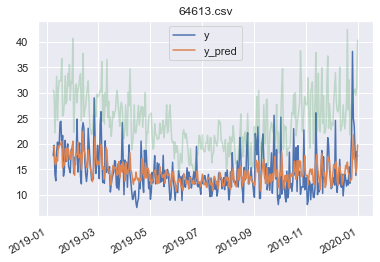

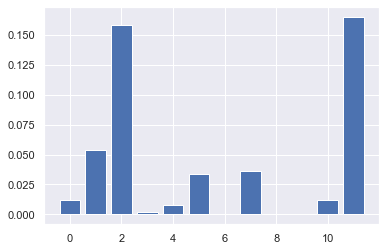

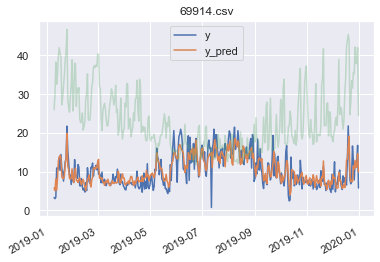

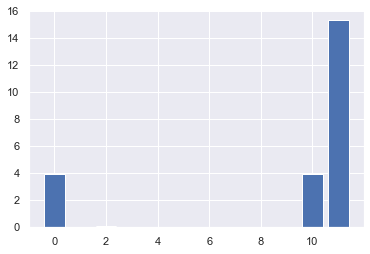

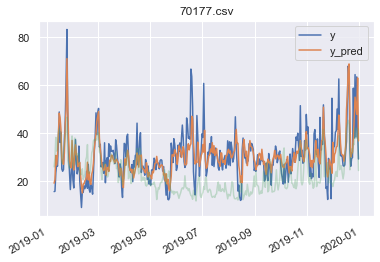

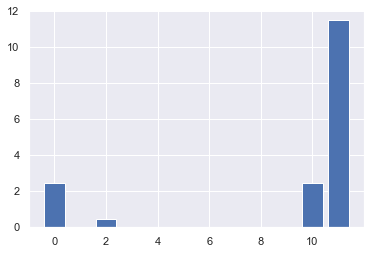

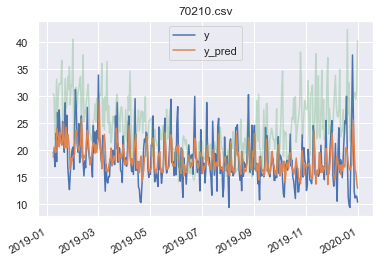

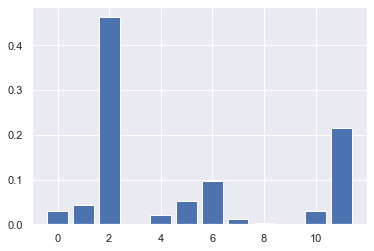

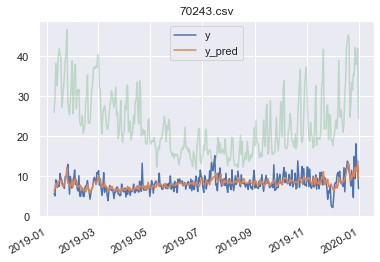

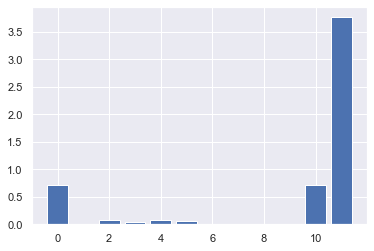

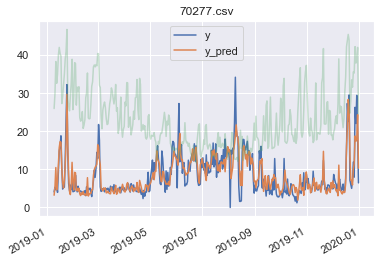

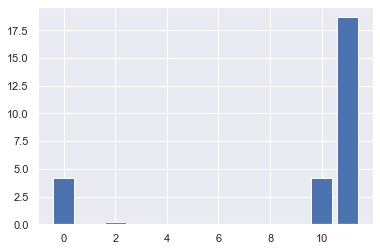

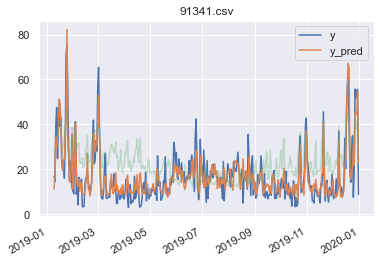

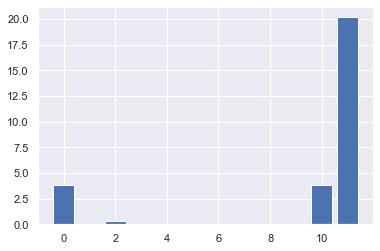

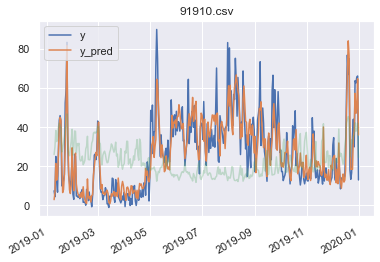

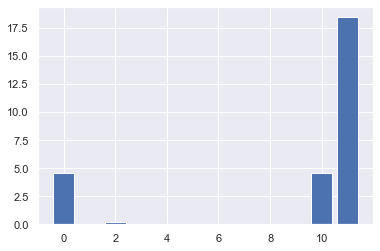

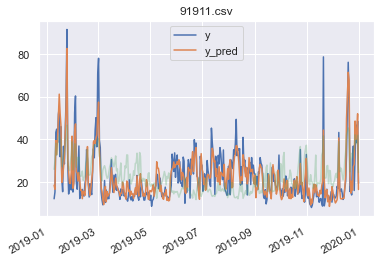

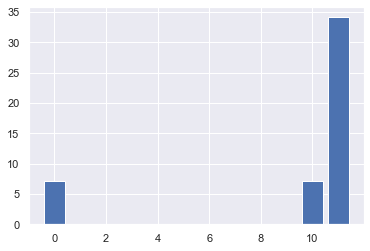

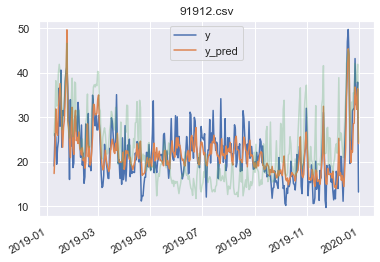

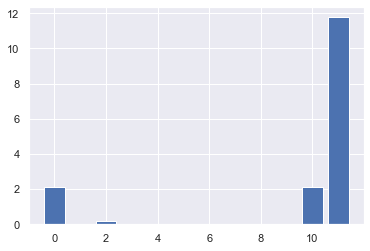

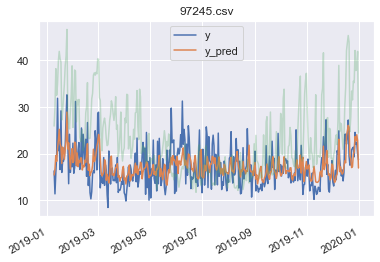

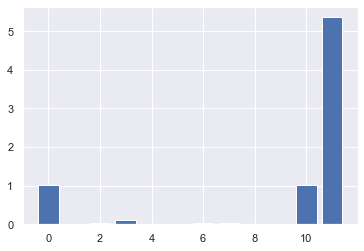

In [5]:
for house in houses:
    print(house.split('.')[0])
    df = extract_data_from_house(house.split('.')[0], load_on=True)
    feature_set = prepare_features(df)

    features = [
            'Maximum temperature (Degree C)',
            'Daily global solar exposure (MJ/m*m)',
            'previous_day',
            'second_previous_day',
            'previous_week',
            'month',
            'weekend_weekday',
            'dayofweek',
            'daily_max'
                ]

    # Drop any NA in the set as it breaks the regression
    d = feature_set.dropna()

    # Collect the features that are linearly dependent
    X = d.loc[:,features[:]].to_numpy()

    # I'm considering only temperature to be 2 degree polynomially fitted
    x_temp = d.loc[:,features[0:1]].to_numpy()
    x_temp = x_temp.reshape(-1,1)
    poly = PolynomialFeatures(degree=2)
    poly_variables = poly.fit_transform(x_temp)

    # This is the target
    y = d.loc[:,'total_use_wo_load'].to_numpy()
    y = y.reshape(-1,1)

    # Combine the Polynomial Feature and Linear Feature
    x = np.concatenate((X, poly_variables), axis=1)
    # x = X
    # Create and train the linear regression model
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    linreg = LinearRegression()
    linreg.fit(x, y)

    # Analyse results
    y_pred = linreg.predict(x)
    print(linreg.score(x, y))
    df = pd.DataFrame(y, columns=['y'], index=d.index)
    df['y_pred'] = y_pred
    ax = df.plot()
    d['Maximum temperature (Degree C)'].plot(ax=ax, label='temp', alpha=0.3)
    ax.set_title(house)
    plt.show()

    # get importance
    from sklearn.inspection import permutation_importance
    results = permutation_importance(linreg, x, y)
    importance = results.importances_mean
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()


In [4]:

# features = ['Maximum temperature (Degree C)',
#             'Daily global solar exposure (MJ/m*m)',
#             'previous_day',
#             'second_previous_day',
#             'previous_week',
#             'month',
#             'weekend_weekday',
#             'dayofweek',
#             'daily_max']
#
# d = feature_set.dropna()
# X = d.loc[:,features[1:]].to_numpy()
# x_temp = d.loc[:,features[0:1]].to_numpy()
# y = d.loc[:,'total_use'].to_numpy()
# poly = PolynomialFeatures(degree=2)
# x_temp = x_temp.reshape(-1,1)
# y = y.reshape(-1,1)
# poly_variables = poly.fit_transform(x_temp)
# x = np.concatenate((X, poly_variables), axis=1)
# linreg = linear_model.LinearRegression()
# linreg.fit(x, y)
# y_pred = linreg.predict(x)
# print(linreg.score(x, y))
# d[features[0]].plot()
# df = pd.DataFrame(y, columns=['y'])
# df['y_pred'] = y_pred
# df.plot()

# sns.regplot(y='total_use_wo_load', x='previous_day', data=data)
# plt.show()
# sns.regplot(y='total_use_wo_load', x='previous_week', data=data)
# plt.show()
# sns.regplot(y='total_use_wo_load', x='Maximum temperature (Degree C)', data=data, order=2)
# plt.show()
# sns.regplot(y='total_use_wo_load', x='Daily global solar exposure (MJ/m*m)', data=data, order=1)
# plt.show()
# x = data.pivot(index='dates', columns='weekend_weekday', values='total_use_wo_load')
# x.boxplot()
# plt.show()
